## Data Exploration

In [2]:
db_dir = "../data/DMRC_GTFS/"

In [3]:
# we start by importing the librairies and datasets
import pandas as pd

agency = pd.read_csv(db_dir + 'agency.txt')
calendar = pd.read_csv(db_dir + "calendar.txt")
routes = pd.read_csv(db_dir + "routes.txt")
shapes = pd.read_csv(db_dir + "shapes.txt")
stop_times = pd.read_csv(db_dir + "stop_times.txt")
stops = pd.read_csv(db_dir + "stops.txt")
trips = pd.read_csv(db_dir + "trips.txt")

db = [agency, calendar, routes, shapes, stop_times, stops, trips]

for data in db:
    for col in data.columns:
        print(col ,end= ", ")
    print()


agency_id, agency_name, agency_url, agency_timezone, agency_lang, agency_phone, agency_fare_url, agency_email, 
service_id, monday, tuesday, wednesday, thursday, friday, saturday, sunday, start_date, end_date, 
route_id, agency_id, route_short_name, route_long_name, route_desc, route_type, route_url, route_color, route_text_color, route_sort_order, continuous_pickup, continuous_drop_off, 
shape_id, shape_pt_lat, shape_pt_lon, shape_pt_sequence, shape_dist_traveled, 
trip_id, arrival_time, departure_time, stop_id, stop_sequence, stop_headsign, pickup_type, drop_off_type, shape_dist_traveled, timepoint, continuous_pickup, continuous_drop_off, 
stop_id, stop_code, stop_name, stop_desc, stop_lat, stop_lon, 
route_id, service_id, trip_id, trip_headsign, trip_short_name, direction_id, block_id, shape_id, wheelchair_accessible, bikes_allowed, 


In [4]:
trips.tail()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
5433,18,weekday,9487,NaN,NaN,NaN,NaN,shp_1_6,0,0
5434,18,weekday,9488,NaN,NaN,NaN,NaN,shp_1_6,0,0
5435,18,weekday,9489,NaN,NaN,NaN,NaN,shp_1_6,0,0
5436,18,weekday,9490,NaN,NaN,NaN,NaN,shp_1_6,0,0
5437,18,weekday,9491,NaN,NaN,NaN,NaN,shp_1_6,0,0


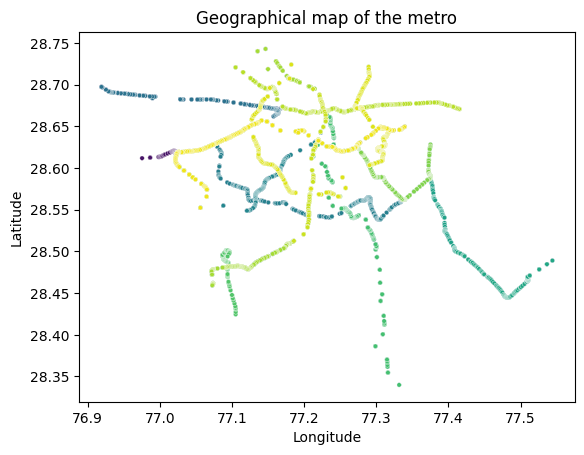

In [5]:
# Lets plot the different paths of the different routes on a map to visualize how the metro works

import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x='shape_pt_lon', y = "shape_pt_lat",hue='shape_id', data = shapes, palette='viridis', s=10, legend=None)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('Geographical map of the metro')
plt.show()


monday       5379
tuesday      5379
wednesday    5379
thursday     5379
friday       5379
saturday       59
sunday          0
dtype: int64


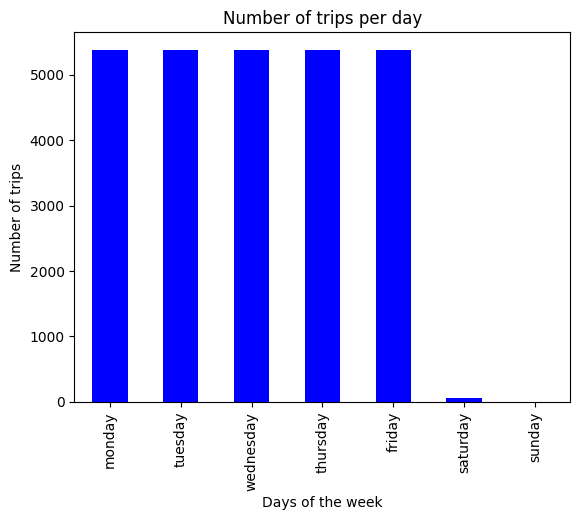

In [6]:
# Next, we will analyze the frequency and scheduling of the trains 

trips_calendar = pd.merge(trips, calendar, how='left', on='service_id')

trips_count = trips_calendar[['monday', 'tuesday', "wednesday", 'thursday', 'friday', 'saturday', 'sunday']].sum()
print(trips_count)

trips_count.plot(kind='bar', color='blue')
plt.title("Number of trips per day")
plt.xlabel("Days of the week")
plt.ylabel("Number of trips")
plt.show()

We can see that the number of trips across the weekdays is consistent. In the weekends, however, the number of trips is not as high as weekdays with it being 0 on sundays.

C:\Users\Norma\AppData\Local\Temp\ipykernel_26480\1152194121.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='stop_lon', y = "stop_lat", data = stops, palette='viridis', s=10, legend=None)


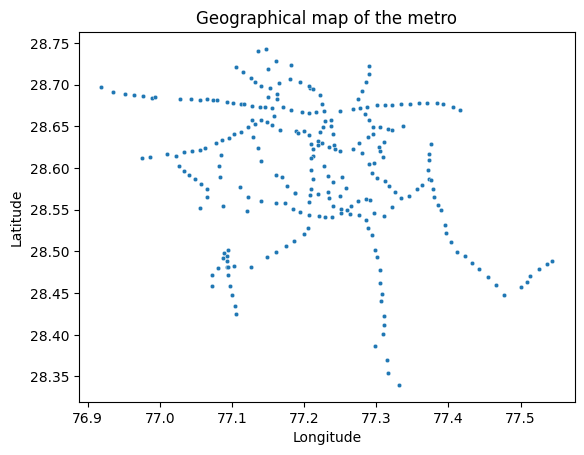

In [7]:
# Lets try to visualize the different stops in a scatter plot
sns.scatterplot(x='stop_lon', y = "stop_lat", data = stops, palette='viridis', s=10, legend=None)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('Geographical map of the metro')
plt.show()

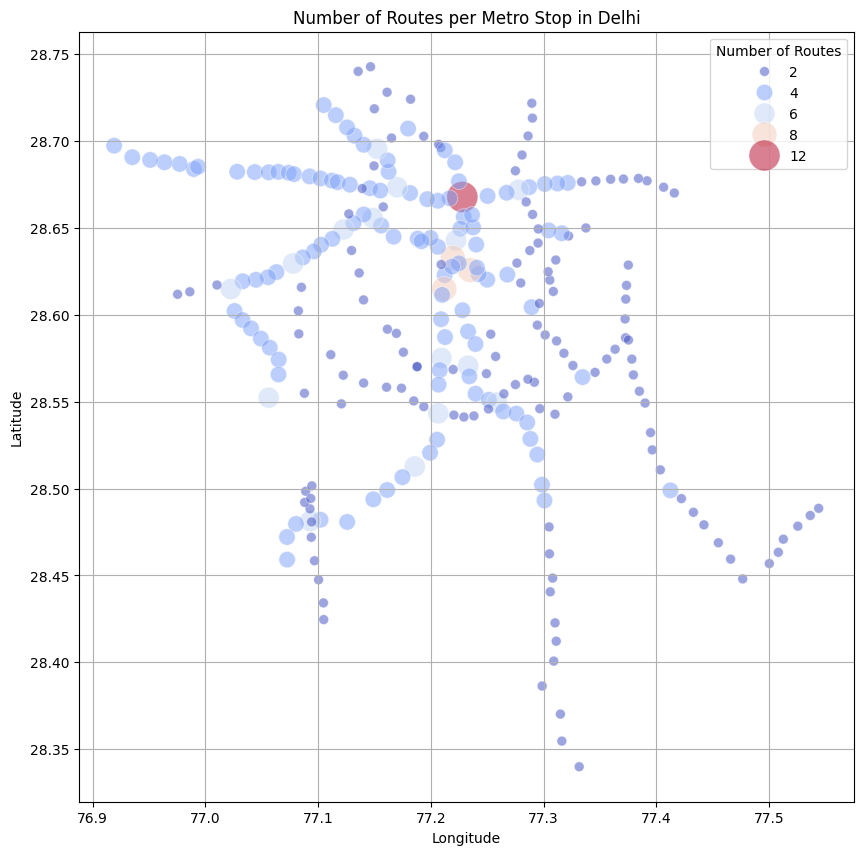

In [8]:
# Now lets try to visualize each stop with how frequently it is being used to get an idea on the trafic of each stop

stops_with_routes = pd.merge(pd.merge(stop_times, trips, on='trip_id'), routes, on='route_id')

# Counting how many unique routes pass through each stop
stop_route_counts = stops_with_routes.groupby("stop_id")["route_id"].nunique().reset_index()
stop_route_counts = stop_route_counts.rename(columns={'route_id': 'number_of_routes'})


# merge this with stops to get the names and location for plotting
stop_route_counts = pd.merge(stop_route_counts, stops, on='stop_id')

# Ploting the stops 
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', size='number_of_routes', hue='number_of_routes',
                sizes=(50, 500), alpha=0.5, palette='coolwarm', data=stop_route_counts)
plt.title('Number of Routes per Metro Stop in Delhi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Number of Routes')
plt.grid(True)
plt.show()


The above plot represents the number of routes that pass through each stop. With bigger circles indicating stops that have more routes pass through them, which makes them buisier than the other routes.

C:\Users\Norma\AppData\Local\Temp\ipykernel_26480\545268430.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_times_intervals["part_of_day"] = stop_times_intervals["arrival_time_dt"].apply(part_of_day)
C:\Users\Norma\AppData\Local\Temp\ipykernel_26480\545268430.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "part_of_day", y="interval_minutes", data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette="mako")


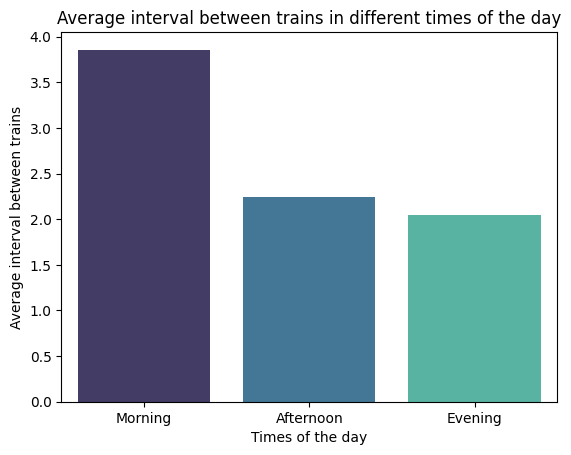

In [23]:
# Next, we will analyze the frequency of trains by examining the time difference between trips in different times of the day
import datetime as dt

def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

stop_times["arrival_time_dt"] = stop_times["arrival_time"].apply(convert_to_time)
stop_times_sorted = stop_times.sort_values(by = ["stop_id", "arrival_time_dt"])
stop_times_sorted["next_arrival_time"] = stop_times_sorted.groupby("stop_id")["arrival_time_dt"].shift(-1)
stop_times_sorted.tail()

# function to calculate the difference in minutes between two times
def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
    full_date_time1 = dt.datetime.combine(dt.date.today(), time1)
    full_date_time2 = dt.datetime.combine(dt.date.today(), time2)
    return (full_date_time2 - full_date_time1).seconds / 60

stop_times_sorted["interval_minutes"] = stop_times_sorted.apply(lambda row : time_difference(row["arrival_time_dt"], row['next_arrival_time']), axis=1 )

# Drop Nan values from the time intervals
stop_times_intervals = stop_times_sorted.dropna(subset=['interval_minutes'])

def part_of_day(time):
    if time < dt.time(12,0):
        return "Morning"
    elif time < dt.time(17,0):
        return "Afternoon"
    else :
        return "Evening"

stop_times_intervals["part_of_day"] = stop_times_intervals["arrival_time_dt"].apply(part_of_day)

# Calculating the average waiting time in the different times of the day
average_intervals = stop_times_intervals.groupby("part_of_day")["interval_minutes"].mean().reset_index()

sns.barplot(x = "part_of_day", y="interval_minutes", data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette="mako")
plt.xlabel("Times of the day")
plt.ylabel("Average interval (minutes)")
plt.title("Average interval between trains in different times of the day")
plt.show()

We can clearly see that the morning intervals are the biggest, which may suggest that the demand on the trains is in its lowest in the morning periods. Then, we can see a significant decrease of the interval between trips in the afternoon and evening, which is likely due to the increase in demand during rush hour zhen people want to go home.

Next, lets calculate the supply in different times of the day

C:\Users\Norma\AppData\Local\Temp\ipykernel_26480\3233174795.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette="Set2")


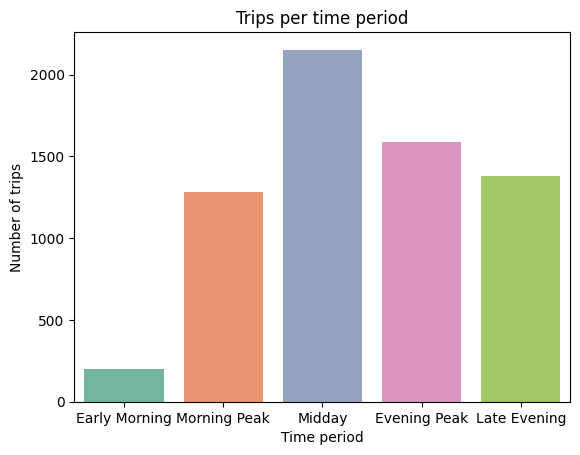

In [29]:
def classify_time_interval(time):
    if time < dt.time(6,0):
        return "Early Morning"
    elif time < dt.time(10,0):
        return "Morning Peak"
    elif time < dt.time(16,0):
        return "Midday"
    elif time < dt.time(20,0):
        return "Evening Peak"
    else : return "Late Evening"

stop_times['time_interval'] = stop_times["arrival_time_dt"].apply(classify_time_interval)

#Counting number of trips per time interval
trips_per_interval = stop_times.groupby("time_interval")["trip_id"].nunique().reset_index()
trips_per_interval = trips_per_interval.rename(columns={"trip_id" : 'number_of_trips'})

# Setting the order 
ordered_intervals = ['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Late Evening']

trips_per_interval["time_interval"] = pd.Categorical(trips_per_interval["time_interval"], categories=ordered_intervals, ordered=True )
trips_per_interval = trips_per_interval.sort_values('time_interval')


sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette="Set2")
plt.title("Trips per time period")
plt.xlabel("Time period")
plt.ylabel("Number of trips")
plt.show()


Here is a breakdown of the results of the above plot:
- Early morning : relatively low number of trips compared to the other periods.
- Morning Peak : Higher number of trips, but still lower than the other; likely due to the morning rush hour, people trying to go to work.
- Midday : Highest number of trips is registered for this period.
- Evening Peak : high number of trips likely explained by the evening rush hour.
- Late Evening : number of trips is lower than the Evening Peak, likely due to people returning late from work or going out for evening related activities.

### Optimizing operations to reduce overcrowding
In order to reduce overcrowding, we would have to get access to the traffic data at each stop in different times of the day. As this infomation is not available, we can only make assumptions and give general ideas on how to improve traffic in metros.

The simplest idea would be to increase the frequency of trains (interval_minutes) during periods of overcrowding. Another idea would be to adjust (adance or delay) the times of the metro trains depending on the times where the overcrowding happens.

However, without the trafic data. It is difficult to test the effectiveness of the different strategies. 